# Zonal mean zonal wind vertical cross sections

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# from matplotlib.offsetbox import AnchoredText

In [2]:
import aeolus.plot as aplt

In [3]:
# Local modules
import mypaths
from calc import spatial_mean, zonal_mean
from commons import MODELS
from names import names
from plot_func import KW_AUX_TTL, KW_MAIN_TTL, KW_SBPLT_LABEL, YLOCS, figsave

In [4]:
plt.style.use("paper.mplstyle")

## Choose case

In [5]:
THAI_cases = ["Hab1", "Hab2"]

## Load the data

Load the time-averaged data previously preprocessed.

In [6]:
# Load data
datasets = {}  # Create an empty dictionary to store all data
# for each of the THAI cases, create a nested directory for models
for THAI_case in THAI_cases:
    datasets[THAI_case] = {}
    for model_key in MODELS.keys():
        model_names = names[model_key]
        ds = xr.open_dataset(mypaths.datadir / model_key / f"{THAI_case}_time_mean_{model_key}.nc")
        if model_key in ["ExoCAM", "LMDG"]:
            lon_slice = slice(None, -1)  # omit the 180E longitude which is repeated
        else:
            lon_slice = slice(None, None)
        new_ds = {}
        for d in ds.data_vars:
            vrbl = ds[d]
            if model_names.x in ds[d].dims:
                vrbl = vrbl.isel(**{model_names.x: lon_slice})
            new_ds[d] = vrbl
        datasets[THAI_case][model_key] = xr.Dataset(new_ds)

In [7]:
VARIABLES = {
    "u": {
        "tex_units": "$m$ $s^{-1}$",
        "title": "Zonal wind",
        "func": lambda ds, mk, *args: ds[names[mk].u],
        "method": "contourf",
        "kw_plt": dict(cmap="RdYlBu_r", levels=np.arange(-100, 101, 10), extend="both"),
    },
}

In [8]:
P_LEVEL = 250  # hPa

Saved to ../plots/Hab1__py_zm_u_logscale.png
Saved to ../plots/Hab2__py_zm_u_logscale.png


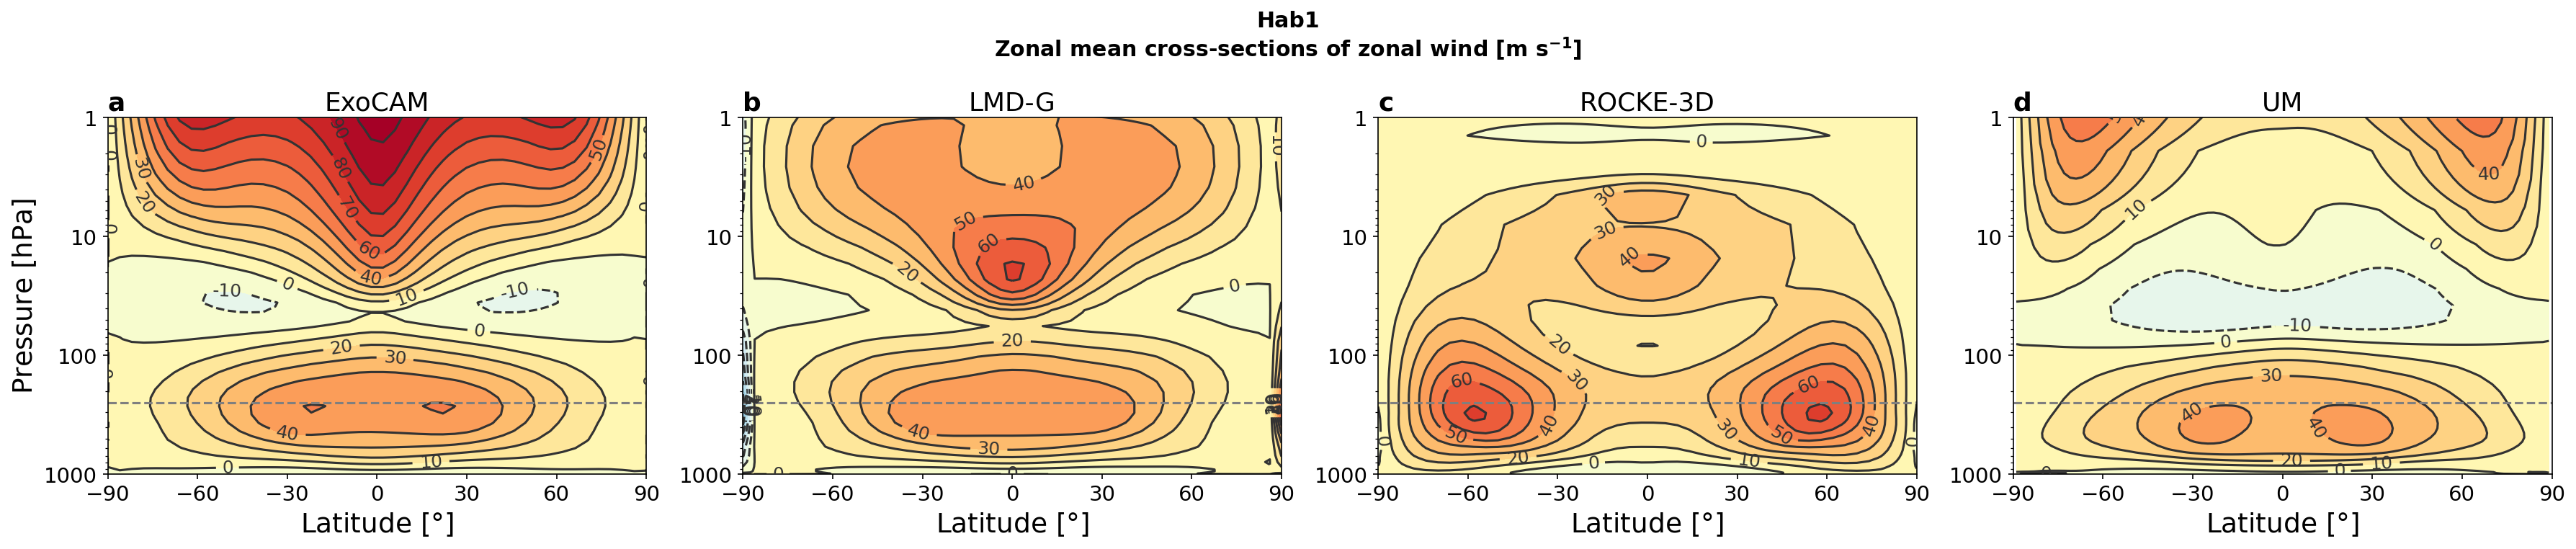

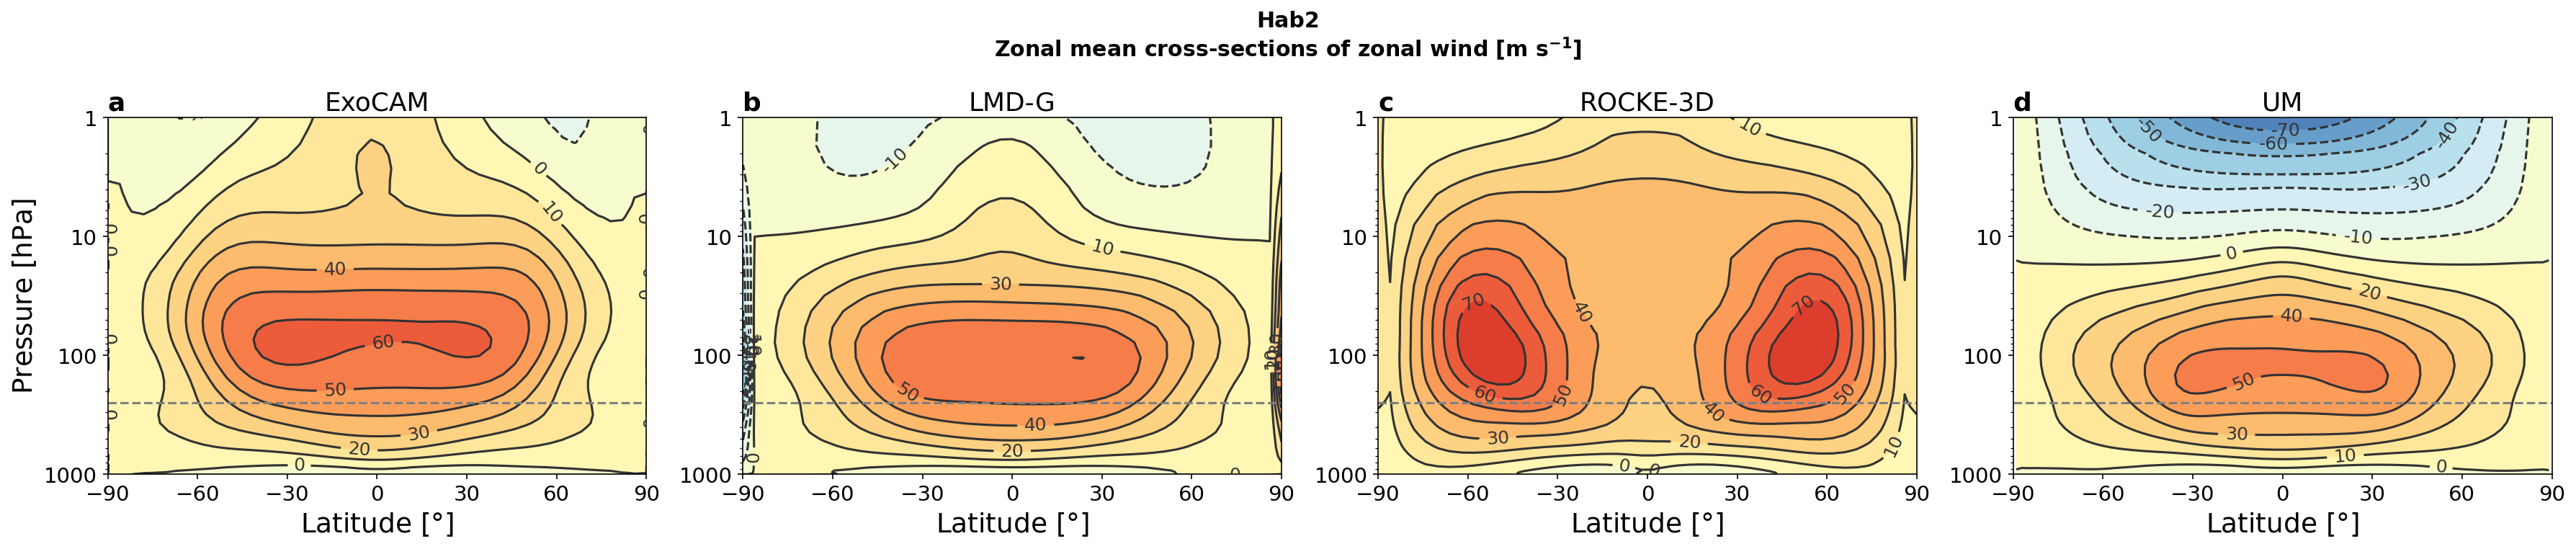

In [9]:
# reduce = lambda a: a.sel(latitude=0, method="nearest")
reduce = zonal_mean
ncols = 4
nrows = len(VARIABLES)

for THAI_case in THAI_cases:
    fig, axs = plt.subplots(
        ncols=ncols, nrows=nrows, figsize=(ncols * 6, nrows * 4.5), squeeze=False
    )
    iletters = aplt.subplot_label_generator()
    for ax in axs.flat:
        ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
        ax.set_yscale("log")
        ax.set_ylim(1000, 1)
        ax.set_yticks([1000, 100, 10, 1])
        ax.set_yticklabels([1000, 100, 10, 1])

        ax.set_xticks(YLOCS)
        ax.set_xlim(-90, 90)
        # for ix in YLOCS[1:-1]:
        #     ax.axvline(ix, color="tab:grey", alpha=0.5)
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("Pressure [$hPa$]")
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Latitude [$\degree$]")
        ax.axhline(P_LEVEL, linestyle="--", color="tab:grey")

    mappables = []
    for (varkey, vardict), axrow in zip(VARIABLES.items(), axs):
        for model_key, ax in zip(MODELS.keys(), axrow):
            ax.set_title(MODELS[model_key]["title"], **KW_MAIN_TTL)
            model_names = names[model_key]
            pres = spatial_mean(datasets[THAI_case][model_key][model_names.pres])
            if model_key != "ROCKE3D":
                # Pa to hPa
                pres /= 1e2
            lats = datasets[THAI_case][model_key][model_names.y]
            arr = vardict["func"](datasets[THAI_case][model_key], model_key)
            arr = reduce(arr)

            cntrf = getattr(ax, vardict["method"])(
                lats,
                pres,
                arr,
                **vardict["kw_plt"],
            )
            cntr = ax.contour(lats, pres, arr, colors="#333333", levels=vardict["kw_plt"]["levels"])
            ax.clabel(cntr, fmt="%.0f", colors="#333333")
        mappables.append(cntrf)

    fig.tight_layout()

    # for cntrf, vardict, axrow in zip(mappables, VARIABLES.values(), axs):
    #     cbar = fig.colorbar(cntrf, ax=axrow, pad=0.01, orientation="vertical", aspect=20)
    #     cbar.ax.set_ylabel(f"{vardict['title']} [{vardict['tex_units']}]")

    ttl = f"Zonal mean cross-sections of {vardict['title'].lower()} [{vardict['tex_units']}]"
    fig.suptitle(f"{THAI_case}\n{ttl}", y=1.125, fontweight="bold")
    figsave(
        fig,
        mypaths.plotdir / f"{THAI_case}__py_zm_u_logscale",
    )

## Constants

Check scale height

In [10]:
import const_ben1_hab1 as const1
import const_ben2_hab2 as const2

In [11]:
scale_height1 = const1.rgas * 240 / const1.gplanet
scale_height2 = const2.rgas * 265 / const2.gplanet

In [12]:
scale_height1, scale_height2

(7551.42547104666, 5487.466158078764)